In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

# 删除重复项

In [6]:
#寻找重复项
client = MongoClient('localhost', 27017)
db = client['中标公示']
collection = db['projects']
pipeline = [
    {"$group": {"_id": {"field1": "$field1", "field2": "$field2"}, "unique_ids": {"$addToSet": "$_id"}, "count": {"$sum": 1}}},
    {"$match": {"count": {"$gt": 1}}}
]
duplicates = collection.aggregate(pipeline)


In [7]:
#删除重复项
for duplicate in duplicates:
    del duplicate['unique_ids'][0]  # 保留一个ID，删除其余的
    for id in duplicate['unique_ids']:
        collection.delete_one({"_id": id})

In [3]:
def read_from_mongodb(host='localhost', port=27017, db_name='中标公示', collection_name='Landscape', start_date=None, end_date=None):
    """
    Read data from MongoDB and return it as a Pandas DataFrame.

    Parameters:
    host (str): MongoDB host address
    port (int): MongoDB port number
    db_name (str): Name of the database
    collection_name (str): Name of the collection
    start_date (datetime): Start date for filtering
    end_date (datetime): End date for filtering

    Returns:
    df (DataFrame): Data as a Pandas DataFrame
    """
    
    # Initialize MongoDB client and select database and collection
    client = MongoClient(host, port)
    db = client[db_name]
    collection = db[collection_name]
    
    # Define query
    query = {}
    if start_date and end_date:
        query = {
            "中标时间": {
                "$gte": start_date,
                "$lt": end_date
            }
        }
    
    # Execute query and convert the result to a list
    cursor = collection.find(query)
    list_cur = list(cursor)
    
    # Convert the list to a Pandas DataFrame
    df = pd.DataFrame(list_cur)
    
    return df

In [4]:

# Example usage
start_date = datetime(2021, 7, 1)
end_date = datetime(2023, 12, 1)
df = read_from_mongodb(start_date=start_date, end_date=end_date)


In [5]:
len(df)

4430

# 数据分析

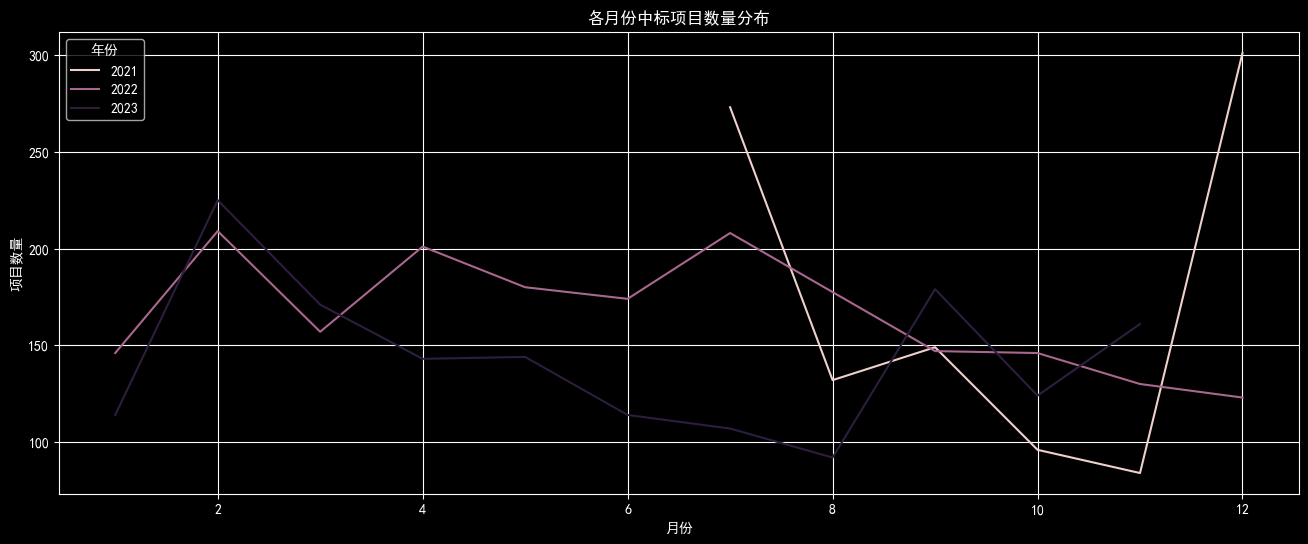

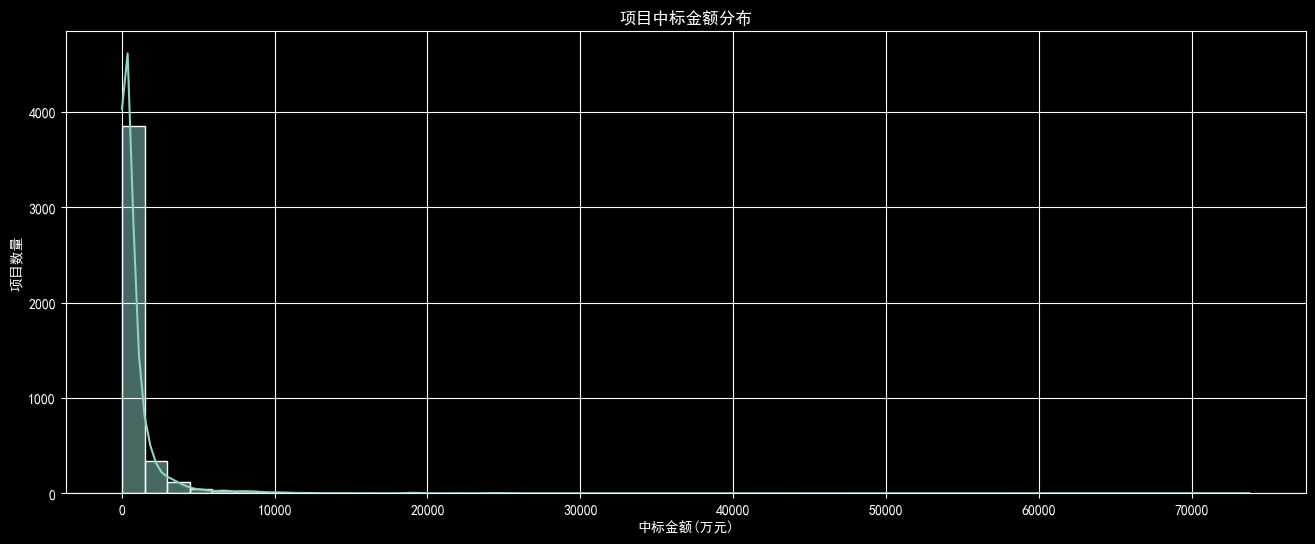

In [6]:
# Extract the month and year from the date
df['中标年份'] = df['中标时间'].dt.year
df['中标月份'] = df['中标时间'].dt.month

# Group by month and count the number of projects and sum the amount
grouped_by_month = df.groupby(['中标年份', '中标月份']).agg({'_id': 'count', '中标金额(万元)': 'sum'}).reset_index()
grouped_by_month.rename(columns={'_id': '项目数量', '中标金额(万元)': '总中标金额(万元)'}, inplace=True)

# Plot by month
plt.figure(figsize=(16, 6))
sns.lineplot(x='中标月份', y='项目数量', hue='中标年份', data=grouped_by_month)
plt.title('各月份中标项目数量分布')
plt.xlabel('月份')
plt.ylabel('项目数量')
plt.legend(title='年份')
plt.grid(True)
plt.show()

# Group by city and count the number of projects and sum the amount
grouped_by_city = df.groupby('城市').agg({'_id': 'count', '中标金额(万元)': 'sum'}).reset_index()
grouped_by_city.rename(columns={'_id': '项目数量', '中标金额(万元)': '总中标金额(万元)'}, inplace=True)

# Group by company and count the number of projects and sum the amount
grouped_by_company = df.groupby('中标公司').agg({'_id': 'count', '中标金额(万元)': 'sum'}).reset_index()
grouped_by_company.rename(columns={'_id': '项目数量', '中标金额(万元)': '总中标金额(万元)'}, inplace=True)

# Plot the distribution of the bid amounts
plt.figure(figsize=(16, 6))
sns.histplot(df['中标金额(万元)'], bins=50, kde=True)
plt.title('项目中标金额分布')
plt.xlabel('中标金额(万元)')
plt.ylabel('项目数量')
plt.grid(True)
plt.show()


In [7]:
df.to_csv('中标公示.csv', encoding='utf-8-sig', index=False)

In [8]:
df.head(5)

,_id,中标时间,项目名称,中标金额(万元),中标公司,城市,中标年份,中标月份
0,6523fe01e56a2f842023b79f,2023-09-28,崔村镇真顺村千亩果园循环道路修复及景观提升工程,320.0,北京绿佳杰园林工程有限公司,北京,2023,9
1,6523fe01e56a2f842023b7a0,2023-09-28,大兴区2023年全龄友好公园改造提升项目,564.0,北京安海之弋园林古建工程有限公司,北京,2023,9
2,6523fe01e56a2f842023b7a1,2023-09-28,房山区长阳镇06、07街区棚户区改造土地开发六片区项目(FS10-0107-0032地块)园...,857.0,北京路桥海威园林绿化有限公司,北京,2023,9
3,6523fe01e56a2f842023b7a2,2023-09-28,房山区长阳镇06、07街区棚户区改造土地开发五片区项目(FS10-0107-0046地块)(...,1065.0,北京市园林设计工程有限公司,北京,2023,9
4,6523fe01e56a2f842023b7a3,2023-09-28,金融街街道绿化养护服务项目（二次）,189.0,北京天赐美景园林绿化工程有限公司,北京,2023,9


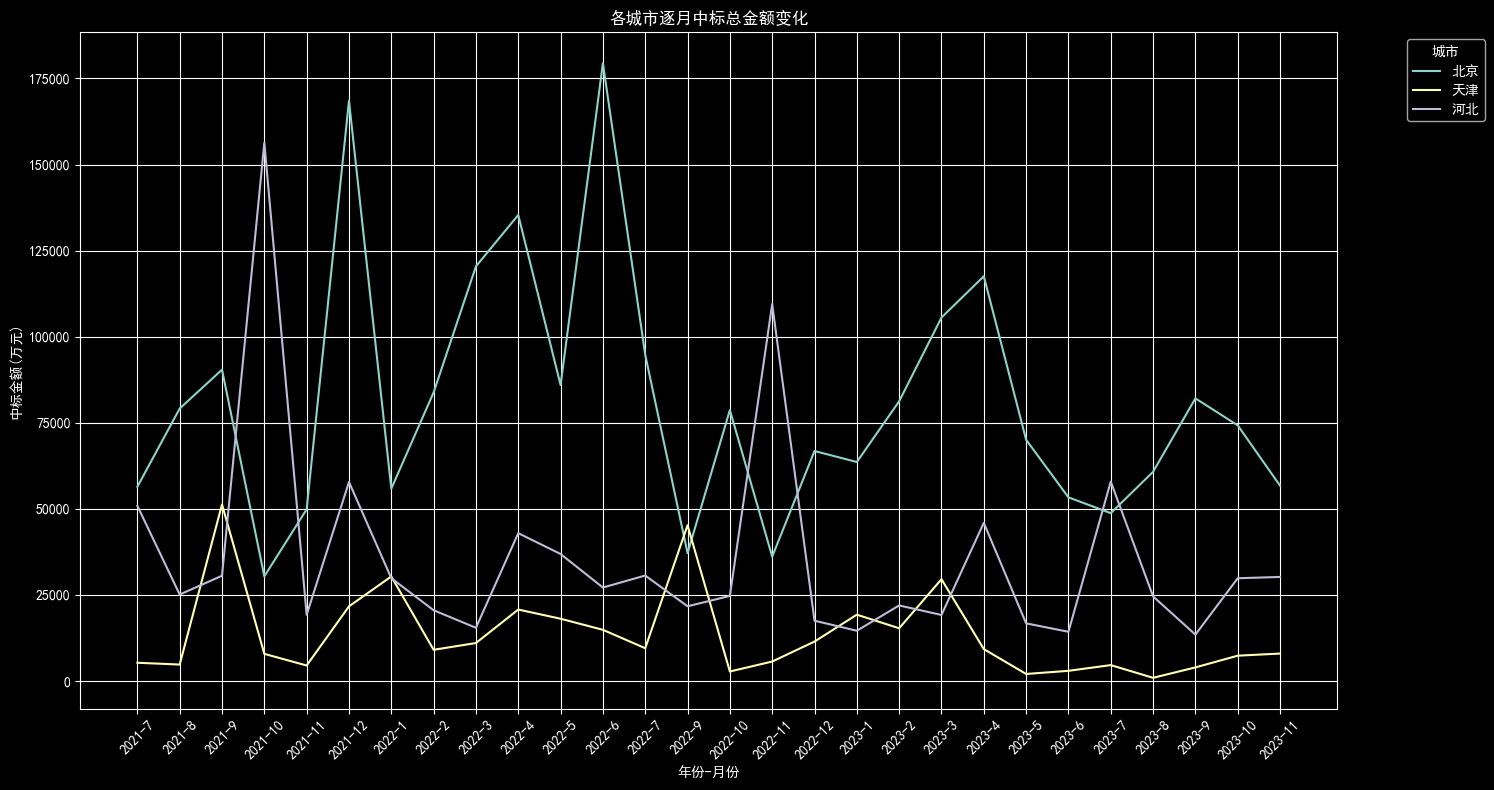

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
data = df.copy()
# 将中标时间转换为datetime对象，便于处理
data['中标时间'] = pd.to_datetime(data['中标时间'])

# 提取年份和月份
data['年份'] = data['中标时间'].dt.year
data['中标月份'] = data['中标时间'].dt.month

# 按年份、月份和城市分组，计算每月每个城市的中标总金额
monthly_city_summary = data.groupby(['年份', '中标月份', '城市']).agg({'中标金额(万元)': 'sum'}).reset_index()

# 获取城市列表
cities = monthly_city_summary['城市'].unique()

# 设置绘图
plt.figure(figsize=(15, 8))

# 为每个城市绘制折线图
for city in cities:
    city_data = monthly_city_summary[monthly_city_summary['城市'] == city]
    plt.plot(city_data['年份'].astype(str) + '-' + city_data['中标月份'].astype(str), city_data['中标金额(万元)'], label=city)

# 设置图表的标题和坐标轴标签
plt.title('各城市逐月中标总金额变化')
plt.xlabel('年份-月份')
plt.ylabel('中标金额(万元)')
plt.xticks(rotation=45)
plt.legend(title='城市', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# 显示图表
plt.show()
